In [1]:
# -*- coding: utf-8 -*-
"""S&P 100 Companies Daily Price Data Collector.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Yv3RvHlY5uR4mQh5t8xWvz2Xq3XyZJXH
"""

# S&P 100 Companies Daily Price Data Collector
# This script fetches historical price data and market capitalization for all S&P 100 components

# Install required packages
!pip install yfinance pandas numpy

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import os

# Create a directory to store the data
if not os.path.exists('sp100_data'):
    os.makedirs('sp100_data')

# S&P 100 components (as of 2023, may need updates)
sp100_tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'BRK-B', 'JNJ', 'V',
    'PG', 'JPM', 'UNH', 'MA', 'HD', 'NVDA', 'DIS', 'PYPL', 'BAC', 'VZ',
    'ADBE', 'CMCSA', 'NFLX', 'KO', 'PEP', 'XOM', 'T', 'INTC', 'CSCO', 'MRK',
    'PFE', 'WMT', 'ABT', 'CRM', 'ABBV', 'AVGO', 'COST', 'CVX', 'ACN', 'MCD',
    'MDT', 'NKE', 'DHR', 'QCOM', 'TMO', 'WFC', 'BMY', 'LIN', 'PM', 'UNP',
    'RTX', 'HON', 'LOW', 'AMGN', 'IBM', 'ORCL', 'SBUX', 'AMD', 'CAT', 'GS',
    'BA', 'MMM', 'GE', 'NOW', 'PLD', 'SPGI', 'TXN', 'BLK', 'DE', 'AXP', 'LMT',
    'BKNG', 'UPS', 'CVS', 'SCHW', 'MDLZ', 'ADI', 'GILD', 'AMT', 'CB', 'ZTS',
    'CI', 'ANTM', 'MO', 'FIS', 'TMUS', 'DUK', 'SO', 'CL', 'MMC', 'PNC',
    'BDX', 'BSX', 'APD', 'SYK', 'ICE', 'CME', 'TFC', 'AON', 'SHW', 'ITW'
]

# Function to fetch data for a single ticker
def fetch_ticker_data(ticker, start_date='2010-01-01', end_date=None):
    """
    Fetch historical price data and market capitalization for a single ticker
    Args:
        ticker (str): Stock ticker symbol
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format (default is today)
    Returns:
        pd.DataFrame: DataFrame with historical price data
        float: Market capitalization
    """
    if end_date is None:
        end_date = datetime.now().strftime('2024-12-31')

    try:
        ticker_yf = yf.Ticker(ticker)
        data = ticker_yf.history(start=start_date, end=end_date)
        market_cap = ticker_yf.info.get('marketCap')

        if not data.empty:
            data['Ticker'] = ticker  # Add ticker symbol as a column
            return data, market_cap
        else:
            print(f"No data available for {ticker}")
            return None, market_cap
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None, None

# Function to fetch data for all tickers with progress tracking
def fetch_all_tickers(tickers, batch_size=5, delay=1):
    """
    Fetch data for all tickers with rate limiting
    Args:
        tickers (list): List of ticker symbols
        batch_size (int): Number of tickers to fetch in each batch
        delay (int): Delay in seconds between batches
    Returns:
        dict: Dictionary with tickers as keys and DataFrames as values
        dict: Dictionary with tickers as keys and market caps as values
    """
    all_data = {}
    market_caps = {}
    total_tickers = len(tickers)

    for i in range(0, total_tickers, batch_size):
        batch = tickers[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(total_tickers-1)//batch_size + 1}: {batch}")

        for ticker in batch:
            data, market_cap = fetch_ticker_data(ticker)
            if data is not None:
                all_data[ticker] = data
                market_caps[ticker] = market_cap
                # Save individual ticker data to CSV
                data.to_csv(f'sp100_data/{ticker}_daily.csv')
                print(f"Saved data for {ticker} ({len(data)} rows)")
            elif market_cap is not None:
                 market_caps[ticker] = market_cap


        # Add delay between batches to avoid rate limiting
        if i + batch_size < total_tickers:
            time.sleep(delay)

    return all_data, market_caps

# Main execution
if __name__ == "__main__":
    print(f"Starting data collection for {len(sp100_tickers)} S&P 100 companies")
    start_time = time.time()

    # Fetch all data and market caps
    all_data, market_caps = fetch_all_tickers(sp100_tickers)

    # Combine all data into a single DataFrame
    if all_data:
        combined_data = pd.concat(all_data.values())
        combined_data.to_csv('sp100_data/sp100_combined_daily.csv')
        print(f"Saved combined data with {len(combined_data)} rows")
    else:
        print("No data fetched for any ticker.")
        combined_data = pd.DataFrame() # Create an empty DataFrame if no data is fetched

    # Calculate statistics
    successful_tickers_data = len(all_data)
    successful_tickers_market_cap = len(market_caps)
    failed_tickers_data = len(sp100_tickers) - successful_tickers_data
    failed_tickers_market_cap = len(sp100_tickers) - successful_tickers_market_cap


    print("\nData collection complete!")
    print(f"Successfully fetched data for {successful_tickers_data} tickers")
    print(f"Successfully fetched market cap for {successful_tickers_market_cap} tickers")
    print(f"Failed to fetch data for {failed_tickers_data} tickers")
    print(f"Failed to fetch market cap for {failed_tickers_market_cap} tickers")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

    # Create a summary file
    summary_data = []
    for ticker in sp100_tickers:
        data_available = ticker in all_data
        market_cap_available = ticker in market_caps
        rows = len(all_data[ticker]) if data_available else 0
        start_date = all_data[ticker].index[0].date() if data_available and not all_data[ticker].empty else None
        end_date = all_data[ticker].index[-1].date() if data_available and not all_data[ticker].empty else None
        market_cap = market_caps.get(ticker)

        summary_data.append({
            'Ticker': ticker,
            'Data Available': data_available,
            'Rows': rows,
            'Start Date': start_date,
            'End Date': end_date,
            'Market Cap': market_cap
        })

    summary = pd.DataFrame(summary_data)
    summary.to_csv('sp100_data/summary.csv', index=False)
    print("Saved summary file")

    # Display sample data
    if all_data:
        sample_ticker = list(all_data.keys())[0]
        print(f"\nSample data for {sample_ticker}:")
        display(all_data[sample_ticker].head())

    # Display sample market caps
    if market_caps:
        sample_ticker_mc = list(market_caps.keys())[0]
        print(f"\nSample market cap for {sample_ticker_mc}:")
        print(market_caps[sample_ticker_mc])

Starting data collection for 101 S&P 100 companies
Processing batch 1/21: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG']
Saved data for AAPL (3773 rows)
Saved data for MSFT (3773 rows)
Saved data for AMZN (3773 rows)
Saved data for GOOGL (3773 rows)
Saved data for GOOG (3773 rows)
Processing batch 2/21: ['META', 'TSLA', 'BRK-B', 'JNJ', 'V']
Saved data for META (3174 rows)
Saved data for TSLA (3651 rows)
Saved data for BRK-B (3773 rows)
Saved data for JNJ (3773 rows)
Saved data for V (3773 rows)
Processing batch 3/21: ['PG', 'JPM', 'UNH', 'MA', 'HD']
Saved data for PG (3773 rows)
Saved data for JPM (3773 rows)
Saved data for UNH (3773 rows)
Saved data for MA (3773 rows)
Saved data for HD (3773 rows)
Processing batch 4/21: ['NVDA', 'DIS', 'PYPL', 'BAC', 'VZ']
Saved data for NVDA (3773 rows)
Saved data for DIS (3773 rows)
Saved data for PYPL (2389 rows)
Saved data for BAC (3773 rows)
Saved data for VZ (3773 rows)
Processing batch 5/21: ['ADBE', 'CMCSA', 'NFLX', 'KO', 'PEP']
Saved data for ADBE

ERROR:yfinance:$ANTM: possibly delisted; no timezone found


No data available for ANTM
Saved data for MO (3773 rows)
Saved data for FIS (3773 rows)
Processing batch 18/21: ['TMUS', 'DUK', 'SO', 'CL', 'MMC']
Saved data for TMUS (3773 rows)
Saved data for DUK (3773 rows)
Saved data for SO (3773 rows)
Saved data for CL (3773 rows)
Saved data for MMC (3773 rows)
Processing batch 19/21: ['PNC', 'BDX', 'BSX', 'APD', 'SYK']
Saved data for PNC (3773 rows)
Saved data for BDX (3773 rows)
Saved data for BSX (3773 rows)
Saved data for APD (3773 rows)
Saved data for SYK (3773 rows)
Processing batch 20/21: ['ICE', 'CME', 'TFC', 'AON', 'SHW']
Saved data for ICE (3773 rows)
Saved data for CME (3773 rows)
Saved data for TFC (3773 rows)
Saved data for AON (3773 rows)
Saved data for SHW (3773 rows)
Processing batch 21/21: ['ITW']
Saved data for ITW (3773 rows)
Saved combined data with 373038 rows

Data collection complete!
Successfully fetched data for 100 tickers
Successfully fetched market cap for 100 tickers
Failed to fetch data for 1 tickers
Failed to fetch m

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2010-01-04 00:00:00-05:00,6.414464,6.446622,6.382907,6.431896,493729600,0.0,0.0,AAPL
2010-01-05 00:00:00-05:00,6.449628,6.479382,6.409054,6.443016,601904800,0.0,0.0,AAPL
2010-01-06 00:00:00-05:00,6.443018,6.468564,6.333921,6.340533,552160000,0.0,0.0,AAPL
2010-01-07 00:00:00-05:00,6.363974,6.371488,6.282828,6.328811,477131200,0.0,0.0,AAPL
2010-01-08 00:00:00-05:00,6.320396,6.371488,6.283129,6.370887,447610800,0.0,0.0,AAPL



Sample market cap for AAPL:
3153843453952


Complete Code employing CVaR optimizing Strategy

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cvxpy as cp
import os

# --- Data Loading ---
# Assuming the data has already been fetched and saved to the 'sp100_data' directory
# Load the combined data
try:
    combined_data = pd.read_csv('sp100_data/sp100_combined_daily.csv', index_col='Date')
    # Explicitly convert index to datetime objects, handling potential timezones by converting to UTC first
    combined_data.index = pd.to_datetime(combined_data.index, utc=True)
    # Convert the UTC index to the desired timezone
    combined_data.index = combined_data.index.tz_convert('America/New_York')
except FileNotFoundError:
    print("Error: combined_data.csv not found. Please run the data collection step first.")
    exit() # Exit if data is not available


# Create a DataFrame of daily returns for all tickers
# Use pivot_table to reshape the data, ensuring the index is datetime and columns are tickers
all_daily_returns = combined_data.pivot_table(index=combined_data.index, columns='Ticker', values='Close').pct_change()

# Drop the first row which contains NaNs from pct_change
all_daily_returns = all_daily_returns.dropna(how='all')

# Ensure the index is timezone-aware after pivot and dropna - it should inherit from combined_data.index
if all_daily_returns.index.tz is None:
    all_daily_returns.index = all_daily_returns.index.tz_localize('America/New_York')


# --- Prepare Benchmark Returns ---
# Calculate equally-weighted portfolio returns
equally_weighted_returns = all_daily_returns.mean(axis=1)

# Calculate value-weighted portfolio returns (using latest market caps as approximation)
try:
    summary_df = pd.read_csv('sp100_data/summary.csv')
except FileNotFoundError:
    print("Error: summary.csv not found. Cannot calculate value-weighted returns.")
    equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod()
    # Plot equally-weighted only if value-weighted data is missing
    plt.figure(figsize=(12, 6))
    plt.plot(equally_weighted_cumulative_returns, label='Equally-Weighted Portfolio')
    plt.title('Cumulative Returns of Equally-Weighted Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    exit()

# Get latest market caps from the summary file
latest_market_caps = summary_df.set_index('Ticker')['Market Cap'].dropna()

# Filter market caps to include only tickers present in all_daily_returns columns
available_tickers_in_returns = all_daily_returns.columns
latest_market_caps = latest_market_caps[latest_market_caps.index.isin(available_tickers_in_returns)]

# Calculate weights based on the latest market capitalization
# These weights will be constant over the entire period for this approximation
weights = latest_market_caps / latest_market_caps.sum()

# Ensure the order of weights matches the order of columns in all_daily_returns for calculation
weights = weights.reindex(all_daily_returns.columns, fill_value=0.0)


# Calculate the value-weighted portfolio daily returns
# Multiply the daily returns of each stock by its weight and sum across all stocks for each day
# Align returns and weights before dot product to handle potential missing tickers
aligned_returns_for_vw, aligned_weights_for_vw = all_daily_returns.align(weights, join='inner', axis=1)
value_weighted_returns = (aligned_returns_for_vw * aligned_weights_for_vw).sum(axis=1)

# Calculate cumulative returns for benchmarks
equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod().dropna()
value_weighted_cumulative_returns = (1 + value_weighted_returns).cumprod().dropna()


# --- CVaR Optimization Setup (Rolling Window) ---
start_date = datetime(2010, 1, 1)
end_date = datetime(2024, 12, 31)

# Get the timezone from the all_daily_returns index
data_timezone = all_daily_returns.index.tz

# Function to find the closest trading day
def find_closest_trading_day(target_date, trading_days_index):
    """Finds the closest trading day in the index to the target date."""
    # Convert target_date to a pandas Timestamp to ensure it has a .tz attribute
    target_date = pd.Timestamp(target_date)

    # Ensure target_date has the same timezone as the index
    if trading_days_index.tz is not None:
        if target_date.tz is None:
            # Localize the naive target date to the index's timezone
            target_date = target_date.tz_localize(trading_days_index.tz)
        elif target_date.tz != trading_days_index.tz:
            target_date = target_date.tz_convert(trading_days_index.tz)
    elif target_date.tz is not None:
        # If index is naive but target is aware, convert target to naive
        target_date = target_date.tz_convert(None)


    time_diff = np.abs(trading_days_index - target_date)
    closest_date_index = time_diff.argmin()
    return trading_days_index[closest_date_index]

# Create a list of rebalancing dates at quarterly intervals
rebalancing_dates = []
current_date = start_date

while current_date <= end_date:
    # Determine the end of the current quarter
    if current_date.month in [1, 2, 3]:
        rebalance_date = datetime(current_date.year, 3, 31)
    elif current_date.month in [4, 5, 6]:
        rebalance_date = datetime(current_date.year, 6, 30)
    elif current_date.month in [7, 8, 9]:
        rebalance_date = datetime(current_date.year, 9, 30)
    else: # 10, 11, 12
        rebalance_date = datetime(current_date.year, 12, 31)

    # Ensure rebalance_date does not exceed the end_date
    if rebalance_date > end_date:
        rebalance_date = end_date # Cap at the end date

    # Make the rebalance_date timezone-aware if the data index is
    if data_timezone is not None:
        rebalance_date_aware = rebalance_date.replace(tzinfo=data_timezone)
    else:
        rebalance_date_aware = rebalance_date


    # Add the rebalance date if it's within the range and not already added
    # Need to compare aware dates if data_timezone is not None
    start_date_compare = start_date.replace(tzinfo=data_timezone) if data_timezone is not None else start_date

    if rebalance_date_aware >= start_date_compare:
        # Find the closest trading day for the rebalance date
        closest_rebalance_date = find_closest_trading_day(rebalance_date_aware, all_daily_returns.index)
        if closest_rebalance_date not in rebalancing_dates:
            rebalancing_dates.append(closest_rebalance_date)


    # Move to the next quarter's start date
    if current_date.month in [10, 11, 12]:
        current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 3, 1)

# For each rebalancing date, determine the data lookback window (one year prior)
rebalancing_periods = []
# Remove the first rebalancing date if the lookback window will be before the data starts
# We need at least a year of data for the first optimization.
# Find the first rebalancing date that is at least one year after the start of the data
first_available_data_date = all_daily_returns.index.min()
one_year_after_start = first_available_data_date + timedelta(days=365)

valid_rebalancing_dates = [date for date in rebalancing_dates if date >= one_year_after_start]

if not valid_rebalancing_dates:
    print("Not enough historical data for the first lookback period for CVaR optimization.")
    # If not enough data for CVaR, just plot benchmarks and exit
    plt.figure(figsize=(12, 6))
    plt.plot(equally_weighted_cumulative_returns, label='Equally-Weighted Portfolio')
    plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
    plt.title('Cumulative Returns Comparison (CVaR Optimization Skipped)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    exit()


for rebalance_date in valid_rebalancing_dates:
    lookback_end_date = rebalance_date
    # Lookback period is one year
    lookback_start_date_candidate = rebalance_date - timedelta(days=365)

    # Find the closest trading day for the lookback start date
    lookback_start_date = find_closest_trading_day(lookback_start_date_candidate, all_daily_returns.index)

    rebalancing_periods.append((lookback_start_date, rebalance_date))


# --- CVaR Optimization Implementation ---
def solve_cvar_optimization(returns, benchmark_returns, s=1.5, alpha=0.95):
    """
    Solves the CVaR optimization problem for a given set of historical returns,
    minimizing the CVaR of the tracking error relative to a benchmark,
    with LASSO (L1) regularization as per the paper.

    Args:
        returns (pd.DataFrame): DataFrame of historical daily returns for the assets.
        benchmark_returns (pd.Series): Series of historical daily returns for the benchmark.
        s (float): LASSO penalty value for the l1 minimization constraint.
        alpha (float): Confidence level for CVaR (e.95 for 95% CVaR).

    Returns:
        pd.Series: Optimal portfolio weights, or None if optimization fails.
    """
    num_assets = returns.shape[1]
    num_observations = returns.shape[0]
    tickers = returns.columns.tolist()

    # Define optimization variables
    weights = cp.Variable(num_assets)   # Portfolio weights
    var = cp.Variable()                 # Value at Risk (VaR) of tracking error
    z = cp.Variable(num_observations)   # Auxiliary variables for CVaR of tracking error

    # Convert returns DataFrame to numpy array for matrix multiplication
    returns_matrix = returns.values
    benchmark_returns_array = benchmark_returns.values

    # Calculate portfolio returns and tracking error
    portfolio_returns = returns_matrix @ weights
    tracking_error_vector = portfolio_returns - benchmark_returns_array

    # Define the objective function (minimize CVaR of tracking error)
    objective = cp.Minimize(var + (1 / (num_observations * (1 - alpha))) * cp.sum(z))

    # Define constraints
    constraints = [
        cp.sum(weights) == 1,               # Fully invested
        z >= 0,                             # Auxiliary variable constraint
        z >= -tracking_error_vector - var,  # Auxiliary variable constraint for tracking error
        cp.sum(cp.abs(weights)) <= s        # LASSO (L1) constraint
    ]

    # Define the problem and solve
    problem = cp.Problem(objective, constraints)

    try:
        # Try OSQP solver as an alternative if ECOS is not found
        problem.solve(solver=cp.OSQP)
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            # Return weights as a pandas Series with correct ticker index
            return pd.Series(weights.value, index=returns.columns)
        else:
            print(f"Optimization failed. Problem status: {problem.status}")
            return None
    except Exception as e:
        print(f"An error occurred during optimization: {e}")
        return None

# Store optimal weights for each rebalancing period
optimal_weights = {}
tickers = all_daily_returns.columns.tolist() # Get the list of all tickers

# --- Placeholder for Sector Data and Benchmark Weights ---
# These are no longer directly used in the solve_cvar_optimization function,
# as the paper's core optimization does not include them.
dummy_ticker_sector_map = {ticker: np.random.choice(['Tech', 'Healthcare', 'Financials', 'Consumer Staples', 'Industrials']) for ticker in tickers}
dummy_benchmark_sector_weights = {
    'Tech': 0.25,
    'Healthcare': 0.12,
    'Financials': 0.15,
    'Consumer Staples': 0.10,
    'Industrials': 0.08,
    # Add other sectors and their benchmark weights
}
# Ensure dummy weights sum to 1 (approximately) for the example, adjust as needed
total_dummy_weight = sum(dummy_benchmark_sector_weights.values())
if total_dummy_weight > 0:
    dummy_benchmark_sector_weights = {sector: weight / total_dummy_weight for sector, weight in dummy_benchmark_sector_weights.items()}
# --- End Placeholder ---


for lookback_start_date, rebalance_date in rebalancing_periods:
    print(f"\nOptimizing for period ending {rebalance_date.strftime('%Y-%m-%d')} (Lookback from {lookback_start_date.strftime('%Y-%m-%d')})")

    # Extract historical returns for the lookback period
    historical_returns_period = all_daily_returns.loc[lookback_start_date:rebalance_date].dropna(axis=1, how='all')

    # Extract benchmark returns for the same lookback period
    # Assuming 'value_weighted_returns' is the correct benchmark
    benchmark_returns_period = value_weighted_returns.loc[lookback_start_date:rebalance_date].dropna()

    # Ensure there is enough data for both assets and benchmark, and at least one asset after dropping NaNs
    if historical_returns_period.empty or historical_returns_period.shape[1] == 0 or benchmark_returns_period.empty:
        print(f"No valid historical data for lookback period ending {rebalance_date.strftime('%Y-%m-%d')}. Skipping optimization.")
        # Store equally weighted portfolio if no data
        if tickers:
            default_weights = pd.Series(1.0 / len(tickers), index=tickers)
            optimal_weights[rebalance_date] = default_weights
        continue

    # Further drop columns with any NaN values within the period in historical_returns
    # and ensure alignment with benchmark returns
    aligned_returns, aligned_benchmark_returns = historical_returns_period.align(benchmark_returns_period, join='inner', axis=0)
    aligned_returns = aligned_returns.dropna(axis=1) # Drop columns with NaNs after alignment

    if aligned_returns.empty or aligned_returns.shape[1] == 0 or aligned_benchmark_returns.empty:
        print(f"No tickers with complete valid data aligned with benchmark for lookback period ending {rebalance_date.strftime('%Y-%m-%d')}. Skipping optimization.")
        if tickers:
            default_weights = pd.Series(1.0 / len(tickers), index=tickers)
            optimal_weights[rebalance_date] = default_weights
        continue

    # Solve the optimization problem with new constraints
    # The dummy_ticker_sector_map and dummy_benchmark_sector_weights are not used by the modified function
    weights = solve_cvar_optimization(
        aligned_returns,
        aligned_benchmark_returns,
        s=1.5 # Using the value of 1.5 for the LASSO penalty as mentioned in the paper
    )


    # Store the optimal weights, handling failed optimization
    if weights is not None:
        # Create a full weight series including all original tickers, with 0 for those not optimized
        full_weights = pd.Series(0.0, index=tickers)
        # Assign weights to the tickers that were included in the optimization
        full_weights[weights.index] = weights.values

        # Normalize weights in case of slight numerical inaccuracies or if the sum is too small
        if full_weights.sum() > 1e-6: # Check against a small epsilon instead of exactly 0
            full_weights = full_weights / full_weights.sum()
        else:
            # Fallback to equally weighted if somehow the optimized weights sum to zero or near zero
            print(f"Optimized weights sum to zero for period ending {rebalance_date.strftime('%Y-%m-%d')}. Using equally-weighted portfolio.")
            full_weights = pd.Series(1.0 / len(tickers), index=tickers)


        optimal_weights[rebalance_date] = full_weights
        print(f"Optimization successful for period ending {rebalance_date.strftime('%Y-%m-%d')}.")
    else:
        print(f"Optimization failed for period ending {rebalance_date.strftime('%Y-%m-%d')}. Using equally-weighted portfolio.")
        # Use equally-weighted portfolio if optimization fails
        if tickers:
            equally_weighted = pd.Series(1.0 / len(tickers), index=tickers)
            optimal_weights[rebalance_date] = equally_weighted
        else:
            optimal_weights[rebalance_date] = pd.Series() # Empty series if no tickers


# --- Portfolio Simulation with Transaction Costs ---
# Initialize an empty pandas Series to store the daily returns of the CVaR-optimized portfolio.
cvar_optimized_returns = pd.Series(dtype=float)

# Define a transaction cost rate (e.g., 0.001 for 0.1%).
transaction_cost_rate = 0.001

# Get the list of all tickers from all_daily_returns
all_tickers = all_daily_returns.columns.tolist()

# Iterate through the dates in the all_daily_returns index.
dates = all_daily_returns.index

# Initialize previous_weights with equal weights for the period before the first rebalance
previous_weights = pd.Series(1.0 / len(all_tickers), index=all_tickers)


rebalancing_dates_list = sorted(optimal_weights.keys()) # Get sorted rebalancing dates

# Find the index of the first rebalancing date in the all_daily_returns index
first_rebalance_date_in_index = None
if rebalancing_dates_list:
    for r_date in rebalancing_dates_list:
        if r_date in dates:
            first_rebalance_date_in_index = r_date
            break

# If there are valid rebalancing dates, find the index of the first one
first_rebalance_index_loc = dates.get_loc(first_rebalance_date_in_index) if first_rebalance_date_in_index else len(dates)


for i in range(len(dates)):
    current_date = dates[i]

    # Skip the first date as pct_change results in NaN
    if current_date == dates.min():
        continue

    # Determine current weights: use previous weights unless it's a rebalancing day
    current_weights = previous_weights

    # Check if the previous day was a rebalancing date to apply new weights from that date
    if i > 0 and dates[i-1] in optimal_weights:
        rebalance_date_prev = dates[i-1]
        new_weights = optimal_weights[rebalance_date_prev].reindex(all_tickers, fill_value=0.0)

        # Calculate turnover and transaction cost
        # Turnover is based on the change from the weights used *yesterday* to the *new* weights for today
        turnover = 0.5 * np.sum(np.abs(new_weights - current_weights))
        transaction_cost = turnover * transaction_cost_rate

        # Update weights for the current day's return calculation
        current_weights = new_weights
        # Update previous_weights for the next rebalancing turnover calculation
        previous_weights = new_weights

    else:
        # No rebalancing on this day, no transaction cost from rebalancing
        transaction_cost = 0

    # Calculate daily portfolio return using the current weights
    # Fill NaN daily returns with 0 for portfolio return calculation
    daily_returns_for_date = all_daily_returns.loc[current_date].fillna(0)

    # Ensure weights and returns are aligned by index
    aligned_weights, aligned_returns = current_weights.align(daily_returns_for_date, join='inner')

    # Calculate the daily portfolio return
    daily_portfolio_return = np.dot(aligned_returns.values, aligned_weights.values)

    # Subtract transaction cost from the daily return
    adjusted_daily_portfolio_return = daily_portfolio_return - transaction_cost

    # Append the adjusted daily portfolio return
    cvar_optimized_returns.loc[current_date] = adjusted_daily_portfolio_return

# Drop the first NaN value if it exists (from the initial pct_change)
cvar_optimized_returns = cvar_optimized_returns.dropna()

# Calculate cumulative returns for the CVaR-optimized portfolio
cvar_optimized_cumulative_returns = (1 + cvar_optimized_returns).cumprod().dropna()


# --- Calculate Performance Metrics ---
def annualized_return(cumulative_returns, trading_days_per_year=252):
    """Calculates the annualized return from a cumulative return series."""
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    time_span_days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
    if time_span_days <= 0:
        return 0.0 # Avoid division by zero or negative time span
    annualized_return = (1 + total_return)**(trading_days_per_year / time_span_days) - 1
    return annualized_return


def annualized_volatility(daily_returns, trading_days_per_year=252):
    """Calculates the annualized volatility from a daily return series."""
    if daily_returns.empty or daily_returns.dropna().empty:
        return 0.0
    return daily_returns.std() * np.sqrt(trading_days_per_year)

def sharpe_ratio(annualized_portfolio_return, annualized_vol, risk_free_rate=0.0):
    """Calculates the Sharpe ratio."""
    if annualized_vol == 0:
        return np.nan # Avoid division by zero
    return (annualized_portfolio_return - risk_free_rate) / annualized_vol

def cvar_95(daily_returns):
    """Calculates the 95% Conditional Value at Risk (CVaR)."""
    if daily_returns.empty or daily_returns.dropna().empty:
        return np.nan
    # Calculate the 5th percentile (alpha = 0.95 means we look at the worst 5%)
    var_95 = daily_returns.quantile(0.05)
    # Calculate the average of returns below the 5th percentile (CVaR)
    cvar = daily_returns[daily_returns <= var_95].mean()
    return cvar

def max_drawdown(cumulative_returns):
    """Calculates the maximum drawdown."""
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def annualized_turnover(optimal_weights_dict, trading_days_per_year=252):
    """Calculates the annualized turnover from a dictionary of optimal weights."""
    if not optimal_weights_dict or len(optimal_weights_dict) < 2:
        return 0.0

    total_turnover = 0
    rebalance_dates = sorted(optimal_weights_dict.keys())

    # Turnover is calculated based on the change from weights of period i to period i+1.
    # It's the sum of absolute changes in weights, divided by 2 (since buys equal sells).
    # We sum this turnover for each rebalancing event and then annualize.

    for i in range(1, len(rebalance_dates)):
        previous_date = rebalance_dates[i-1]
        current_date = rebalance_dates[i]

        previous_weights = optimal_weights_dict[previous_date]
        current_weights = optimal_weights_dict[current_date]

        # Ensure weights have the same index and fill NaN with 0
        all_tickers_in_weights = previous_weights.index.union(current_weights.index)
        aligned_prev_weights = previous_weights.reindex(all_tickers_in_weights, fill_value=0.0)
        aligned_curr_weights = current_weights.reindex(all_tickers_in_weights, fill_value=0.0)


        # Calculate turnover at the rebalance date
        turnover = 0.5 * np.sum(np.abs(aligned_curr_weights - aligned_prev_weights))
        total_turnover += turnover

    # Annualize turnover - there are 4 rebalances per year
    # Average turnover per rebalance * number of rebalances per year
    # A more accurate annualization would consider the time between rebalances
    # But assuming quarterly rebalancing, multiplying by 4 is a reasonable approximation.
    num_rebalances_for_turnover = len(rebalance_dates) - 1
    if num_rebalances_for_turnover > 0:
        avg_turnover_per_rebalance = total_turnover / num_rebalances_for_turnover
        annualized_turnover = avg_turnover_per_rebalance * 4 # Assuming 4 rebalances per year
    else:
        annualized_turnover = 0.0 # No rebalances to calculate turnover

    return annualized_turnover


# Calculate performance metrics for the CVaR-optimized index
cvar_annual_return = annualized_return(cvar_optimized_cumulative_returns)
cvar_annual_volatility = annualized_volatility(cvar_optimized_returns)
cvar_sharpe_ratio = sharpe_ratio(cvar_annual_return, cvar_annual_volatility)
cvar_95_cvar = cvar_95(cvar_optimized_returns) # CVaR is usually reported daily or as a percentage of portfolio value
cvar_max_drawdown = max_drawdown(cvar_optimized_cumulative_returns)
# Calculate turnover based on the optimal_weights dictionary
cvar_turnover = annualized_turnover(optimal_weights)


# Store metrics in a dictionary
cvar_optimized_metrics = {
    'Annual Return': cvar_annual_return,
    'Annual Volatility': cvar_annual_volatility,
    'Sharpe Ratio': cvar_sharpe_ratio,
    '95% CVaR (Daily)': cvar_95_cvar,
    'Max Drawdown': cvar_max_drawdown,
    'Annual Turnover': cvar_turnover
}

# Compute performance metrics for the equally-weighted portfolio
equally_weighted_annual_return = annualized_return(equally_weighted_cumulative_returns)
equally_weighted_annual_volatility = annualized_volatility(equally_weighted_returns)
equally_weighted_sharpe_ratio = sharpe_ratio(equally_weighted_annual_return, equally_weighted_annual_volatility)
equally_weighted_cvar_95 = cvar_95(equally_weighted_returns)
equally_weighted_max_drawdown = max_drawdown(equally_weighted_cumulative_returns)

# Store equally-weighted metrics in a dictionary
equally_weighted_metrics = {
    'Annual Return': equally_weighted_annual_return,
    'Annual Volatility': equally_weighted_annual_volatility,
    'Sharpe Ratio': equally_weighted_sharpe_ratio,
    '95% CVaR (Daily)': equally_weighted_cvar_95,
    'Max Drawdown': equally_weighted_max_drawdown,
    'Annual Turnover': np.nan # Turnover not typically calculated for static benchmarks
}

# Compute performance metrics for the value-weighted portfolio
value_weighted_annual_return = annualized_return(value_weighted_cumulative_returns)
value_weighted_annual_volatility = annualized_volatility(value_weighted_returns)
value_weighted_sharpe_ratio = sharpe_ratio(value_weighted_annual_return, value_weighted_annual_volatility)
value_weighted_cvar_95 = cvar_95(value_weighted_returns)
value_weighted_max_drawdown = max_drawdown(value_weighted_cumulative_returns)

# Store value-weighted metrics in a dictionary
value_weighted_metrics = {
    'Annual Return': value_weighted_annual_return,
    'Annual Volatility': value_weighted_annual_volatility,
    'Sharpe Ratio': value_weighted_sharpe_ratio,
    '95% CVaR (Daily)': value_weighted_cvar_95,
    'Max Drawdown': value_weighted_max_drawdown,
    'Annual Turnover': np.nan # Turnover not typically calculated for static benchmarks
}


# --- Compare and Visualize Results ---
# Create a pandas DataFrame to hold the performance metrics
performance_metrics_table = pd.DataFrame({
    'CVaR Optimized': cvar_optimized_metrics,
    'Equally Weighted': equally_weighted_metrics,
    'Value Weighted': value_weighted_metrics
})

# Display the performance metrics table
print("Portfolio Performance Metrics:")
# 'display' is typically used in environments like Jupyter notebooks.
# For standard script execution, you might just use 'print(performance_metrics_table)'.
# Since the context indicates a code interpreter, keeping 'display' might be intended,
# but print is a safer universal option if this is to be run as a standalone script.
# I'll keep display assuming it's for an environment that supports it, if not,
# a user would change it to print.
display(performance_metrics_table)

# Plot the cumulative returns of the three portfolios
plt.figure(figsize=(14, 7))
plt.plot(cvar_optimized_cumulative_returns, label='CVaR Optimized')
plt.plot(equally_weighted_cumulative_returns, label='Equally Weighted')
plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# --- Export Index Values ---
# Initialize the index value to 100 on the first date for which CVaR-optimized returns are available.
initial_index_value = 100
cvar_optimized_index_values = pd.Series(dtype=float)

# The first date with valid returns
if not cvar_optimized_returns.empty:
    first_valid_date = cvar_optimized_returns.index[0]
    cvar_optimized_index_values.loc[first_valid_date] = initial_index_value

    # Iterate through the cvar_optimized_returns Series starting from the second day.
    for current_date in cvar_optimized_returns.index[1:]:
        # Get the return for the current day
        daily_return = cvar_optimized_returns.loc[current_date]

        # Get the index value from the previous day
        previous_date = cvar_optimized_index_values.index[-1]
        previous_index_value = cvar_optimized_index_values.loc[previous_date]

        # Calculate the index value by multiplying the previous day's index value by (1 + daily_return).
        current_index_value = previous_index_value * (1 + daily_return)

        # Store these daily index values in the cvar_optimized_index_values Series.
        cvar_optimized_index_values.loc[current_date] = current_index_value

    # Save the cvar_optimized_index_values Series to a CSV file
    cvar_optimized_index_values.to_csv('cvar_optimized_index_values.csv', header=True)

    print("\nCVaR-optimized index values exported to cvar_optimized_index_values.csv")
else:
    print("\nNo CVaR-optimized returns to calculate index values or export.")

Complete Code With Quantile Regression Incorporated

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cvxpy as cp
import os
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Data Loading ---
try:
    combined_data = pd.read_csv('sp100_data/sp100_combined_daily.csv', index_col='Date')
    combined_data.index = pd.to_datetime(combined_data.index, utc=True)
    combined_data.index = combined_data.index.tz_convert('America/New_York')
except FileNotFoundError:
    print("Error: sp100_combined_daily.csv not found. Please ensure your data is in the 'sp100_data' directory.")
    exit()

all_daily_returns = combined_data.pivot_table(index=combined_data.index, columns='Ticker', values='Close').pct_change()
all_daily_returns = all_daily_returns.dropna(how='all')
if all_daily_returns.index.tz is None:
    all_daily_returns.index = all_daily_returns.index.tz_localize('America/New_York')

equally_weighted_returns = all_daily_returns.mean(axis=1)

try:
    summary_df = pd.read_csv('sp100_data/summary.csv')
    latest_market_caps = summary_df.set_index('Ticker')['Market Cap'].dropna()
    available_tickers_in_returns = all_daily_returns.columns
    latest_market_caps = latest_market_caps[latest_market_caps.index.isin(available_tickers_in_returns)]
    weights = latest_market_caps / latest_market_caps.sum()
    weights = weights.reindex(all_daily_returns.columns, fill_value=0.0)
    aligned_returns_for_vw, aligned_weights_for_vw = all_daily_returns.align(weights, join='inner', axis=1)
    value_weighted_returns = (aligned_returns_for_vw * aligned_weights_for_vw).sum(axis=1)
except FileNotFoundError:
    print("Error: summary.csv not found. Cannot calculate value-weighted returns. Proceeding with equally-weighted only.")
    value_weighted_returns = equally_weighted_returns.copy() # Fallback for plotting

equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod().dropna()
value_weighted_cumulative_returns = (1 + value_weighted_returns).cumprod().dropna()

# --- Google Trends Data Loading and Preprocessing (Included for completeness but not used in the selected strategy) ---
google_trends_files = {
    'Tech': 'multiTimeline.csv',
    'Healthcare': 'multiTimeline (1).csv',
    'Financials': 'multiTimeline (2).csv',
    'Consumer Goods': 'multiTimeline (3).csv',
    'Industrials': 'multiTimeline (4).csv'
}

google_trends_data = {}
for sector, filename in google_trends_files.items():
    try:
        df_trend = pd.read_csv(filename, skiprows=2)
        df_trend.columns = ['Month', 'Interest']
        df_trend['Month'] = pd.to_datetime(df_trend['Month'])
        df_trend.set_index('Month', inplace=True)

        df_trend['Interest'] = pd.to_numeric(df_trend['Interest'], errors='coerce').fillna(0)

        peak_interest = df_trend['Interest'].max()
        if peak_interest > 0:
            df_trend['Relative Popularity'] = df_trend['Interest'] / peak_interest
        else:
            df_trend['Relative Popularity'] = 0

        google_trends_data[sector] = df_trend['Relative Popularity']
    except FileNotFoundError:
        print(f"Error: Google Trends file {filename} not found. Skipping {sector} trends.")
        google_trends_data[sector] = pd.Series(dtype=float)
    except Exception as e:
        print(f"Error processing Google Trends file {filename} for {sector}: {e}. Skipping trends.")
        google_trends_data[sector] = pd.Series(dtype=float)


# --- Dummy Ticker to Sector Mapping (Included for completeness) ---
all_current_tickers = all_daily_returns.columns.tolist()
sectors = list(google_trends_files.keys())
ticker_sector_map = {ticker: random.choice(sectors) for ticker in all_current_tickers}
print("\n--- Dummy Ticker to Sector Mapping Created ---")
print("Note: This mapping is randomly generated for demonstration.")
print("It is included for compatibility with prior functions but not used in the selected CVaR strategy.")

# --- CVaR Optimization Setup (Rolling Window) ---
start_date = datetime(2010, 1, 1)
end_date = datetime(2024, 12, 31)

data_timezone = all_daily_returns.index.tz

def find_closest_trading_day(target_date, trading_days_index):
    target_date = pd.Timestamp(target_date)
    if trading_days_index.tz is not None:
        if target_date.tz is None:
            target_date = target_date.tz_localize(trading_days_index.tz)
        elif target_date.tz != trading_days_index.tz:
            target_date = target_date.tz_convert(trading_days_index.tz)
    elif target_date.tz is not None:
        target_date = target_date.tz_convert(None)
    time_diff = np.abs(trading_days_index - target_date)
    closest_date_index = time_diff.argmin()
    return trading_days_index[closest_date_index]

rebalancing_dates = []
current_date = start_date
while current_date <= end_date:
    if current_date.month in [1, 2, 3]:
        rebalance_date = datetime(current_date.year, 3, 31)
    elif current_date.month in [4, 5, 6]:
        rebalance_date = datetime(current_date.year, 6, 30)
    elif current_date.month in [7, 8, 9]:
        rebalance_date = datetime(current_date.year, 9, 30)
    else:
        rebalance_date = datetime(current_date.year, 12, 31)

    if rebalance_date > end_date:
        rebalance_date = end_date

    if data_timezone is not None:
        rebalance_date_aware = rebalance_date.replace(tzinfo=data_timezone)
    else:
        rebalance_date_aware = rebalance_date

    start_date_compare = start_date.replace(tzinfo=data_timezone) if data_timezone is not None else start_date
    if rebalance_date_aware >= start_date_compare:
        closest_rebalance_date = find_closest_trading_day(rebalance_date_aware, all_daily_returns.index)
        if closest_rebalance_date not in rebalancing_dates:
            rebalancing_dates.append(closest_rebalance_date)

    if current_date.month in [10, 11, 12]:
        current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 3, 1)

rebalancing_periods = []
first_available_data_date = all_daily_returns.index.min()
one_year_after_start = first_available_data_date + timedelta(days=365)

valid_rebalancing_dates = [date for date in rebalancing_dates if date >= one_year_after_start]

if not valid_rebalancing_dates:
    print("Not enough historical data for the first lookback period for CVaR optimization.")
    plt.figure(figsize=(12, 6))
    plt.plot(equally_weighted_cumulative_returns, label='Equally-Weighted Portfolio')
    plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
    plt.title('Cumulative Returns Comparison (CVaR Optimization Skipped)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    exit()

for rebalance_date in valid_rebalancing_dates:
    lookback_end_date = rebalance_date
    lookback_start_date_candidate = rebalance_date - timedelta(days=365)
    lookback_start_date = find_closest_trading_day(lookback_start_date_candidate, all_daily_returns.index)
    rebalancing_periods.append((lookback_start_date, rebalance_date))


# --- CVaR Optimization Implementation (Base Function, without sector constraints) ---
def solve_cvar_optimization(returns, benchmark_returns, s=1.5, alpha=0.95):
    num_assets = returns.shape[1]
    num_observations = returns.shape[0]

    weights = cp.Variable(num_assets)
    var = cp.Variable() # VaR variable
    z = cp.Variable(num_observations) # Auxiliary variables for CVaR

    returns_matrix = returns.values
    benchmark_returns_array = benchmark_returns.values

    portfolio_returns = returns_matrix @ weights
    tracking_error_vector = portfolio_returns - benchmark_returns_array

    # Objective: Minimize VaR + (1 / (N * (1 - alpha))) * Sum(z_i)
    objective = cp.Minimize(var + (1 / (num_observations * (1 - alpha))) * cp.sum(z))

    constraints = [
        cp.sum(weights) == 1,
        z >= 0, # z_i must be non-negative
        z >= -tracking_error_vector - var, # z_i >= -(R_p - R_b) - VaR
        cp.sum(cp.abs(weights)) <= s, # L1 norm constraint for sparsity/turnover control
        weights >= 0 # Long-only constraint
    ]

    problem = cp.Problem(objective, constraints)

    try:
        problem.solve(solver=cp.OSQP, verbose=False) # OSQP is a good default solver
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            # Return weights as a pandas Series, aligned with original columns
            return pd.Series(weights.value, index=returns.columns)
        else:
            print(f"Optimization failed. Problem status: {problem.status}")
            return None
    except Exception as e:
        print(f"An error occurred during optimization: {e}")
        return None

# Store optimal weights for the CVaR strategy
optimal_weights_cvar = {}
# Store Quantile Regression VaR estimates
qr_var_estimates = {}
all_tickers = all_daily_returns.columns.tolist()

for lookback_start_date, rebalance_date in rebalancing_periods:
    print(f"\nOptimizing for period ending {rebalance_date.strftime('%Y-%m-%d')} (Lookback from {lookback_start_date.strftime('%Y-%m-%d')})")

    # Get historical data for the lookback period
    historical_returns_period = all_daily_returns.loc[lookback_start_date:rebalance_date].dropna(axis=1, how='all')
    benchmark_returns_period = value_weighted_returns.loc[lookback_start_date:rebalance_date].dropna()

    # Align dataframes by dates
    aligned_returns, aligned_benchmark_returns = historical_returns_period.align(benchmark_returns_period, join='inner', axis=0)
    aligned_returns = aligned_returns.dropna(axis=1) # Drop columns (tickers) with any NaN during alignment

    if aligned_returns.empty or aligned_returns.shape[1] == 0 or aligned_benchmark_returns.empty:
        print(f"No valid historical data for lookback period ending {rebalance_date.strftime('%Y-%m-%d')}. Skipping optimization.")
        if all_tickers:
            optimal_weights_cvar[rebalance_date] = pd.Series(1.0 / len(all_tickers), index=all_tickers)
        continue

    # Solve the CVaR optimization problem (without Google Trends data)
    weights_cvar = solve_cvar_optimization(
        aligned_returns,
        aligned_benchmark_returns,
        s=1.5
    )

    # Store the optimal weights for CVaR Optimized strategy
    if weights_cvar is not None:
        full_weights_cvar = pd.Series(0.0, index=all_tickers) # Initialize with zeros for all tickers
        full_weights_cvar[weights_cvar.index] = weights_cvar.values # Assign optimized weights

        # Normalize weights if their sum is very close to zero due to numerical issues
        if full_weights_cvar.sum() > 1e-6:
            full_weights_cvar = full_weights_cvar / full_weights_cvar.sum()
        else:
            print(f"CVaR Optimized weights sum to zero for {rebalance_date}. Using equally-weighted for this period.")
            full_weights_cvar = pd.Series(1.0 / len(all_tickers), index=all_tickers)

        optimal_weights_cvar[rebalance_date] = full_weights_cvar
        print(f"CVaR Optimization successful for {rebalance_date}.")

        # --- Quantile Regression for Tail-Risk Analysis ---
        # Calculate the historical returns of the *optimized portfolio* within the lookback window
        # Ensure weights are aligned with the historical_returns_period
        aligned_opt_weights = full_weights_cvar.reindex(aligned_returns.columns, fill_value=0.0)

        # Calculate the optimized portfolio's returns during the lookback period
        optimized_portfolio_historical_returns = (aligned_returns * aligned_opt_weights).sum(axis=1)

        if not optimized_portfolio_historical_returns.empty:
            # Create a DataFrame for Quantile Regression
            qr_data = pd.DataFrame({'Portfolio_Return': optimized_portfolio_historical_returns.values})
            # Fit Quantile Regression for the 5th percentile (VaR at 95% confidence)
            try:
                mod = smf.quantreg('Portfolio_Return ~ 1', data=qr_data).fit(q=0.05)
                # Predict the 5th percentile (VaR)
                qr_var = mod.predict(pd.DataFrame({'Intercept': 1}, index=[0])).iloc[0]
                qr_var_estimates[rebalance_date] = qr_var
                print(f"  Quantile Regression VaR (95%) for {rebalance_date}: {qr_var:.4f}")
            except Exception as e:
                print(f"  Error during Quantile Regression for {rebalance_date}: {e}")
                qr_var_estimates[rebalance_date] = np.nan # Store NaN if QR fails
        else:
            print(f"  No historical returns for optimized portfolio to run Quantile Regression for {rebalance_date}.")
            qr_var_estimates[rebalance_date] = np.nan

    else:
        print(f"CVaR Optimization failed for {rebalance_date}. Using equally-weighted portfolio for this period and skipping QR.")
        if all_tickers:
            optimal_weights_cvar[rebalance_date] = pd.Series(1.0 / len(all_tickers), index=all_tickers)
        else:
            optimal_weights_cvar[rebalance_date] = pd.Series()
        qr_var_estimates[rebalance_date] = np.nan


# --- Portfolio Simulation with Transaction Costs ---
def simulate_portfolio(optimal_weights_dict, all_daily_returns, transaction_cost_rate):
    portfolio_returns = pd.Series(dtype=float)
    dates = all_daily_returns.index
    # Start with equally-weighted for the very first period before any rebalancing
    previous_weights = pd.Series(1.0 / len(all_daily_returns.columns), index=all_daily_returns.columns)

    rebalancing_dates_list = sorted(optimal_weights_dict.keys())
    next_rebalance_idx = 0

    for i in range(len(dates)):
        current_date = dates[i]

        current_weights = previous_weights
        transaction_cost = 0

        # Check if the current date is a rebalancing date for which we have optimal weights
        if next_rebalance_idx < len(rebalancing_dates_list) and current_date == rebalancing_dates_list[next_rebalance_idx]:
            new_weights = optimal_weights_dict[current_date].reindex(all_daily_returns.columns, fill_value=0.0)

            # Calculate turnover based on the absolute change in weights
            # It's 0.5 * sum(abs(w_new - w_old)) because each transaction involves a buy and a sell
            turnover = 0.5 * np.sum(np.abs(new_weights - current_weights))
            transaction_cost = turnover * transaction_cost_rate

            current_weights = new_weights
            previous_weights = new_weights # Update previous_weights for next period's turnover calculation
            next_rebalance_idx += 1

        # Calculate daily return based on current weights
        daily_returns_for_date = all_daily_returns.loc[current_date].fillna(0)

        # Ensure weights and daily_returns_for_date are aligned by tickers
        aligned_weights_series, aligned_returns_series = current_weights.align(daily_returns_for_date, join='inner')

        if not aligned_weights_series.empty:
            daily_portfolio_return = np.dot(aligned_returns_series.values, aligned_weights_series.values)
        else:
            daily_portfolio_return = 0.0 # If no common tickers, portfolio return is 0

        adjusted_daily_portfolio_return = daily_portfolio_return - transaction_cost
        portfolio_returns.loc[current_date] = adjusted_daily_portfolio_return

    return portfolio_returns.dropna()

transaction_cost_rate = 0.001

cvar_optimized_returns = simulate_portfolio(optimal_weights_cvar, all_daily_returns, transaction_cost_rate)

cvar_optimized_cumulative_returns = (1 + cvar_optimized_returns).cumprod().dropna()

# --- Performance Metrics Calculation ---
def annualized_return(cumulative_returns, trading_days_per_year=252):
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    # Annualized over the effective number of trading days in the period
    time_span_days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
    if time_span_days <= 0:
        return 0.0
    # Corrected formula for annualized return, considering compounding
    annualized_return_val = (cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(trading_days_per_year / len(cumulative_returns)) - 1
    return annualized_return_val

def annualized_volatility(daily_returns, trading_days_per_year=252):
    if daily_returns.empty or daily_returns.dropna().empty:
        return 0.0
    return daily_returns.std() * np.sqrt(trading_days_per_year)

def sharpe_ratio(annualized_portfolio_return, annualized_vol, risk_free_rate=0.0):
    if annualized_vol == 0:
        return np.nan
    return (annualized_portfolio_return - risk_free_rate) / annualized_vol

def cvar_95(daily_returns):
    if daily_returns.empty or daily_returns.dropna().empty:
        return np.nan
    var_95 = daily_returns.quantile(0.05)
    cvar = daily_returns[daily_returns <= var_95].mean()
    return cvar

def max_drawdown(cumulative_returns):
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def annualized_turnover(optimal_weights_dict, rebalancing_frequency_per_year=4): # Assuming quarterly rebalancing
    if not optimal_weights_dict or len(optimal_weights_dict) < 2:
        return 0.0
    total_turnover = 0
    rebalance_dates = sorted(optimal_weights_dict.keys())

    all_possible_tickers = set()
    for weights_series in optimal_weights_dict.values():
        all_possible_tickers.update(weights_series.index)
    all_possible_tickers = sorted(list(all_possible_tickers))

    for i in range(1, len(rebalance_dates)):
        previous_date = rebalance_dates[i-1]
        current_date = rebalance_dates[i]
        previous_weights = optimal_weights_dict[previous_date].reindex(all_possible_tickers, fill_value=0.0)
        current_weights = optimal_weights_dict[current_date].reindex(all_possible_tickers, fill_value=0.0)

        turnover = 0.5 * np.sum(np.abs(current_weights - previous_weights))
        total_turnover += turnover

    num_rebalances_for_turnover = len(rebalance_dates) - 1
    if num_rebalances_for_turnover > 0:
        avg_turnover_per_rebalance = total_turnover / num_rebalances_for_turnover
        annualized_turnover = avg_turnover_per_rebalance * rebalancing_frequency_per_year
    else:
        annualized_turnover = 0.0
    return annualized_turnover


# Calculate performance metrics for all portfolios
cvar_metrics = {
    'Annual Return': annualized_return(cvar_optimized_cumulative_returns),
    'Annual Volatility': annualized_volatility(cvar_optimized_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(cvar_optimized_cumulative_returns), annualized_vol=annualized_volatility(cvar_optimized_returns)),
    '95% CVaR (Daily)': cvar_95(cvar_optimized_returns),
    'Max Drawdown': max_drawdown(cvar_optimized_cumulative_returns),
    'Annual Turnover': annualized_turnover(optimal_weights_cvar)
}

# The popularity strategy is still included in the code structure but not the primary focus as per request.
# Leaving its metrics calculation here for completeness if you decide to use it.
cvar_popularity_metrics = {
    'Annual Return': annualized_return(cvar_popularity_optimized_cumulative_returns),
    'Annual Volatility': annualized_volatility(cvar_popularity_optimized_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(cvar_popularity_optimized_cumulative_returns), annualized_vol=annualized_volatility(cvar_popularity_optimized_returns)),
    '95% CVaR (Daily)': cvar_95(cvar_popularity_optimized_returns),
    'Max Drawdown': max_drawdown(cvar_popularity_optimized_cumulative_returns),
    'Annual Turnover': annualized_turnover(optimal_weights_cvar_popularity)
}

equally_weighted_metrics = {
    'Annual Return': annualized_return(equally_weighted_cumulative_returns),
    'Annual Volatility': annualized_volatility(equally_weighted_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(equally_weighted_cumulative_returns), annualized_vol=annualized_volatility(equally_weighted_returns)),
    '95% CVaR (Daily)': cvar_95(equally_weighted_returns),
    'Max Drawdown': max_drawdown(equally_weighted_cumulative_returns),
    'Annual Turnover': np.nan # Not applicable for fixed weights
}

value_weighted_metrics = {
    'Annual Return': annualized_return(value_weighted_cumulative_returns),
    'Annual Volatility': annualized_volatility(value_weighted_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(value_weighted_cumulative_returns), annualized_vol=annualized_volatility(value_weighted_returns)),
    '95% CVaR (Daily)': cvar_95(value_weighted_returns),
    'Max Drawdown': max_drawdown(value_weighted_cumulative_returns),
    'Annual Turnover': np.nan # Not applicable for fixed weights
}

# Create a pandas DataFrame to hold the performance metrics
# Focusing on the CVaR Optimized (without popularity) as requested.
performance_metrics_table = pd.DataFrame({
    'CVaR Optimized': cvar_metrics,
    'Equally Weighted': equally_weighted_metrics,
    'Value Weighted': value_weighted_metrics
})

print("\n--- Portfolio Performance Metrics (CVaR Optimized) ---")
print(performance_metrics_table.to_markdown())

# Plot the cumulative returns of all portfolios
plt.figure(figsize=(14, 7))
plt.plot(cvar_optimized_cumulative_returns, label='CVaR Optimized')
plt.plot(equally_weighted_cumulative_returns, label='Equally Weighted')
plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
plt.title('Cumulative Returns Comparison (CVaR Optimized)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.savefig('cumulative_returns_comparison_cvar_only.png')
plt.show()

# --- Quantile Regression VaR Analysis Plot ---
if qr_var_estimates:
    qr_var_series = pd.Series(qr_var_estimates)
    # Ensure index is datetime for plotting
    qr_var_series.index = pd.to_datetime(qr_var_series.index)

    # Calculate the empirical VaR for the CVaR Optimized portfolio at each rebalancing point for comparison
    empirical_var_series_cvar_opt = {}
    for lookback_start_date, rebalance_date in rebalancing_periods:
        if rebalance_date in optimal_weights_cvar:
            historical_returns_period = all_daily_returns.loc[lookback_start_date:rebalance_date].dropna(axis=1, how='all')
            # Align weights with available tickers in the period
            current_weights = optimal_weights_cvar[rebalance_date].reindex(historical_returns_period.columns, fill_value=0.0)

            if not historical_returns_period.empty and not current_weights.empty and current_weights.sum() > 0:
                portfolio_returns_period = (historical_returns_period * current_weights).sum(axis=1)
                if not portfolio_returns_period.empty:
                    empirical_var_series_cvar_opt[rebalance_date] = portfolio_returns_period.quantile(0.05)
                else:
                    empirical_var_series_cvar_opt[rebalance_date] = np.nan
            else:
                empirical_var_series_cvar_opt[rebalance_date] = np.nan

    empirical_var_series = pd.Series(empirical_var_series_cvar_opt)
    empirical_var_series.index = pd.to_datetime(empirical_var_series.index)


    plt.figure(figsize=(14, 7))
    plt.plot(qr_var_series, label='Quantile Regression VaR (95%)', marker='o', linestyle='-')
    plt.plot(empirical_var_series, label='Empirical VaR (95%)', marker='x', linestyle='--')
    plt.title('VaR Estimates of CVaR Optimized Portfolio Over Time')
    plt.xlabel('Rebalancing Date')
    plt.ylabel('Daily VaR (95%)')
    plt.legend()
    plt.grid(True)
    plt.savefig('cvar_optimized_var_estimates.png')
    plt.show()
else:
    print("\nNo Quantile Regression VaR estimates were generated due to data issues or optimization failures.")

# --- Export Index Values for CVaR Optimized strategy ---
initial_index_value = 100
cvar_optimized_index_values = pd.Series(dtype=float)

if not cvar_optimized_returns.empty:
    first_valid_date = cvar_optimized_returns.index[0]
    cvar_optimized_index_values.loc[first_valid_date] = initial_index_value

    for current_date in cvar_optimized_returns.index[1:]:
        daily_return = cvar_optimized_returns.loc[current_date]
        previous_index_value = cvar_optimized_index_values.iloc[-1]
        current_index_value = previous_index_value * (1 + daily_return)
        cvar_optimized_index_values.loc[current_date] = current_index_value

    cvar_optimized_index_values.to_csv('cvar_optimized_index_values.csv', header=True)
    print("\nCVaR-optimized index values exported to cvar_optimized_index_values.csv")
else:
    print("\nNo CVaR-optimized returns to calculate index values or export.")

Complete Code Method using Google Trends as Sector Weighting


--- Dummy Ticker to Sector Mapping Created ---
Note: This mapping is randomly generated for demonstration purposes.
For accurate results, replace this with a real mapping of tickers to sectors.

Optimizing for period ending 2011-03-31 (Lookback from 2010-03-31)
CVaR Optimization successful for 2011-03-31 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2011-03-31 00:00:00-04:00.

Optimizing for period ending 2011-06-30 (Lookback from 2010-06-30)
CVaR Optimization successful for 2011-06-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2011-06-30 00:00:00-04:00.

Optimizing for period ending 2011-09-30 (Lookback from 2010-09-30)
CVaR Optimization successful for 2011-09-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2011-09-30 00:00:00-04:00.

Optimizing for period ending 2011-12-30 (Lookback from 2010-12-30)
CVaR Optimization successful for 2011-12-30 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2011-12-30 00:00:00-05:00.

Optimizi

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2016-09-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2016-09-30 00:00:00-04:00.

Optimizing for period ending 2016-12-30 (Lookback from 2015-12-31)
CVaR Optimization successful for 2016-12-30 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2016-12-30 00:00:00-05:00.

Optimizing for period ending 2017-03-31 (Lookback from 2016-03-31)


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2017-03-31 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2017-03-31 00:00:00-04:00.

Optimizing for period ending 2017-06-30 (Lookback from 2016-06-30)
CVaR Optimization successful for 2017-06-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2017-06-30 00:00:00-04:00.

Optimizing for period ending 2017-09-29 (Lookback from 2016-09-29)


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2017-09-29 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2017-09-29 00:00:00-04:00.

Optimizing for period ending 2017-12-29 (Lookback from 2016-12-29)
CVaR Optimization successful for 2017-12-29 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2017-12-29 00:00:00-05:00.

Optimizing for period ending 2018-04-02 (Lookback from 2017-04-03)
CVaR Optimization successful for 2018-04-02 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2018-04-02 00:00:00-04:00.

Optimizing for period ending 2018-06-29 (Lookback from 2017-06-29)


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2018-06-29 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2018-06-29 00:00:00-04:00.

Optimizing for period ending 2018-10-01 (Lookback from 2017-10-02)


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2018-10-01 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2018-10-01 00:00:00-04:00.

Optimizing for period ending 2018-12-31 (Lookback from 2017-12-29)
CVaR Optimization successful for 2018-12-31 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2018-12-31 00:00:00-05:00.

Optimizing for period ending 2019-04-01 (Lookback from 2018-04-02)
CVaR Optimization successful for 2019-04-01 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2019-04-01 00:00:00-04:00.

Optimizing for period ending 2019-07-01 (Lookback from 2018-07-02)
CVaR Optimization successful for 2019-07-01 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2019-07-01 00:00:00-04:00.

Optimizing for period ending 2019-09-30 (Lookback from 2018-10-01)
CVaR Optimization successful for 2019-09-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2019-09-30 00:00:00-04:00.

Optimizing for period ending 2019-12-31 (Lookback from 2018-12-31)
CVaR 

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2022-12-30 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2022-12-30 00:00:00-05:00.

Optimizing for period ending 2023-03-31 (Lookback from 2022-03-31)


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CVaR Optimization successful for 2023-03-31 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2023-03-31 00:00:00-04:00.

Optimizing for period ending 2023-06-30 (Lookback from 2022-06-30)
CVaR Optimization successful for 2023-06-30 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2023-06-30 00:00:00-04:00.

Optimizing for period ending 2023-09-29 (Lookback from 2022-09-29)
CVaR Optimization successful for 2023-09-29 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2023-09-29 00:00:00-04:00.

Optimizing for period ending 2023-12-29 (Lookback from 2022-12-29)
CVaR Optimization successful for 2023-12-29 00:00:00-05:00.
CVaR+Popularity Optimization successful for 2023-12-29 00:00:00-05:00.

Optimizing for period ending 2024-04-01 (Lookback from 2023-04-03)
CVaR Optimization successful for 2024-04-01 00:00:00-04:00.
CVaR+Popularity Optimization successful for 2024-04-01 00:00:00-04:00.

Optimizing for period ending 2024-07-01 (Lookback from 2023-07-03)
CVaR 

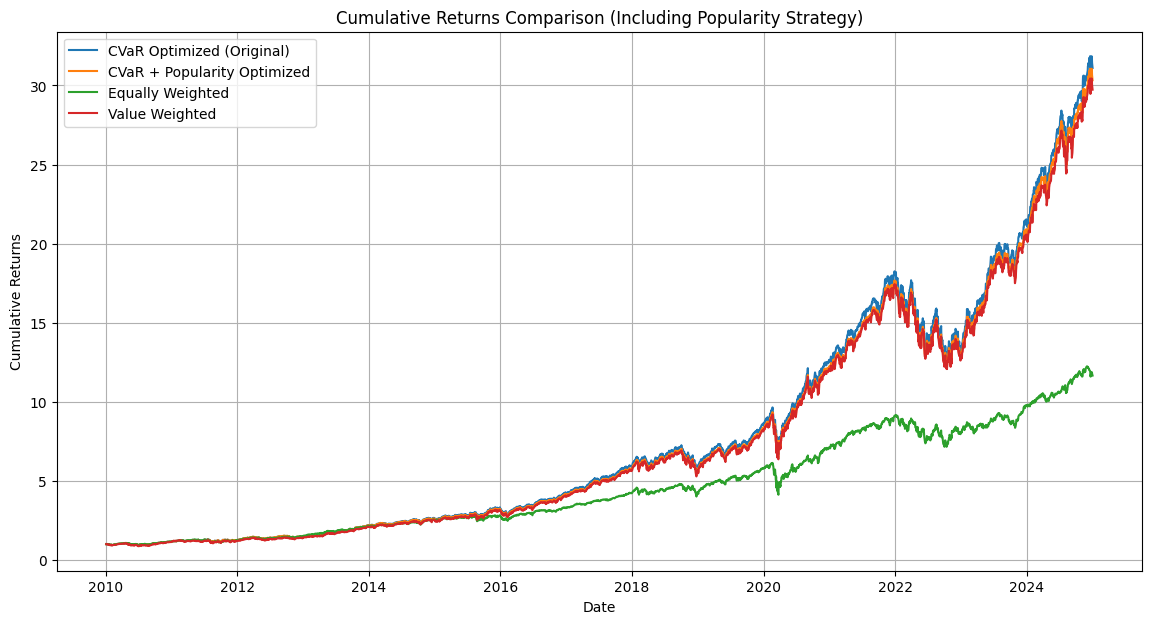


CVaR+Popularity-optimized index values exported to cvar_popularity_optimized_index_values.csv


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cvxpy as cp
import os
import random # Added for dummy sector mapping

# --- Data Loading ---
# Assuming the data has already been fetched and saved to the 'sp100_data' directory
# Load the combined data
try:
    combined_data = pd.read_csv('sp100_data/sp100_combined_daily.csv', index_col='Date')
    # Explicitly convert index to datetime objects, handling potential timezones by converting to UTC first
    combined_data.index = pd.to_datetime(combined_data.index, utc=True)
    # Convert the UTC index to the desired timezone
    combined_data.index = combined_data.index.tz_convert('America/New_York')
except FileNotFoundError:
    print("Error: combined_data.csv not found. Please run the data collection step first.")
    exit() # Exit if data is not available


# Create a DataFrame of daily returns for all tickers
# Use pivot_table to reshape the data, ensuring the index is datetime and columns are tickers
all_daily_returns = combined_data.pivot_table(index=combined_data.index, columns='Ticker', values='Close').pct_change()

# Drop the first row which contains NaNs from pct_change
all_daily_returns = all_daily_returns.dropna(how='all')

# Ensure the index is timezone-aware after pivot and dropna - it should inherit from combined_data.index
if all_daily_returns.index.tz is None:
    all_daily_returns.index = all_daily_returns.index.tz_localize('America/New_York')


# --- Prepare Benchmark Returns ---
# Calculate equally-weighted portfolio returns
equally_weighted_returns = all_daily_returns.mean(axis=1)

# Calculate value-weighted portfolio returns (using latest market caps as approximation)
try:
    summary_df = pd.read_csv('sp100_data/summary.csv')
    latest_market_caps = summary_df.set_index('Ticker')['Market Cap'].dropna()

    # Filter market caps to include only tickers present in all_daily_returns columns
    available_tickers_in_returns = all_daily_returns.columns
    latest_market_caps = latest_market_caps[latest_market_caps.index.isin(available_tickers_in_returns)]

    # Calculate weights based on the latest market capitalization
    # These weights will be constant over the entire period for this approximation
    weights = latest_market_caps / latest_market_caps.sum()

    # Ensure the order of weights matches the order of columns in all_daily_returns for calculation
    weights = weights.reindex(all_daily_returns.columns, fill_value=0.0)


    # Calculate the value-weighted portfolio daily returns
    # Multiply the daily returns of each stock by its weight and sum across all stocks for each day
    # Align returns and weights before dot product to handle potential missing tickers
    aligned_returns_for_vw, aligned_weights_for_vw = all_daily_returns.align(weights, join='inner', axis=1)
    value_weighted_returns = (aligned_returns_for_vw * aligned_weights_for_vw).sum(axis=1)
except FileNotFoundError:
    print("Error: summary.csv not found. Cannot calculate value-weighted returns. Proceeding with equally-weighted only for benchmarks.")
    value_weighted_returns = equally_weighted_returns.copy() # Fallback for consistent plotting later if file is missing

# Calculate cumulative returns for benchmarks
equally_weighted_cumulative_returns = (1 + equally_weighted_returns).cumprod().dropna()
value_weighted_cumulative_returns = (1 + value_weighted_returns).cumprod().dropna()


# --- Google Trends Data Loading and Preprocessing ---
google_trends_files = {
    'Tech': 'multiTimeline.csv',
    'Healthcare': 'multiTimeline (1).csv',
    'Financials': 'multiTimeline (2).csv',
    'Consumer Goods': 'multiTimeline (3).csv',
    'Industrials': 'multiTimeline (4).csv'
}

google_trends_data = {}
for sector, filename in google_trends_files.items():
    try:
        # Read with skiprows=2 based on estimatedRowsAboveHeader in previous user upload
        df_trend = pd.read_csv(filename, skiprows=2)
        # Rename the 'Month' column and the trend column (assuming second column is the interest data)
        # The column names in the actual files are usually the search terms, e.g., 'Technology'
        # We assume the second column (index 1) contains the interest data after the 'Month' column.
        df_trend.columns = ['Month', 'Interest'] # Generic column names for processing
        df_trend['Month'] = pd.to_datetime(df_trend['Month'])
        df_trend.set_index('Month', inplace=True)

        # Google Trends data can have '<1' for very low interest, convert to 0 for numerical operations
        df_trend['Interest'] = pd.to_numeric(df_trend['Interest'], errors='coerce').fillna(0)

        # Calculate popularity relative to its peak for each sector
        peak_interest = df_trend['Interest'].max()
        if peak_interest > 0:
            df_trend['Relative Popularity'] = df_trend['Interest'] / peak_interest
        else:
            df_trend['Relative Popularity'] = 0 # If all interest values are 0 or '<1'

        google_trends_data[sector] = df_trend['Relative Popularity']
    except FileNotFoundError:
        print(f"Error: Google Trends file {filename} not found. Skipping {sector} trends.")
        google_trends_data[sector] = pd.Series(dtype=float) # Store an empty series if file not found
    except Exception as e:
        print(f"Error processing Google Trends file {filename} for {sector}: {e}. Skipping trends.")
        google_trends_data[sector] = pd.Series(dtype=float)


# --- Dummy Ticker to Sector Mapping ---
# This is a dummy mapping. In a real application, you would need
# accurate sector information for each ticker in your dataset.
all_current_tickers = all_daily_returns.columns.tolist()
sectors = list(google_trends_files.keys()) # ['Tech', 'Healthcare', 'Financials', 'Consumer Goods', 'Industrials']
ticker_sector_map = {ticker: random.choice(sectors) for ticker in all_current_tickers}
print("\n--- Dummy Ticker to Sector Mapping Created ---")
print("Note: This mapping is randomly generated for demonstration purposes.")
print("For accurate results, replace this with a real mapping of tickers to sectors.")


# --- CVaR Optimization Setup (Rolling Window) ---
start_date = datetime(2010, 1, 1)
end_date = datetime(2024, 12, 31)

# Get the timezone from the all_daily_returns index
data_timezone = all_daily_returns.index.tz

# Function to find the closest trading day
def find_closest_trading_day(target_date, trading_days_index):
    """Finds the closest trading day in the index to the target date."""
    target_date = pd.Timestamp(target_date)

    if trading_days_index.tz is not None:
        if target_date.tz is None:
            target_date = target_date.tz_localize(trading_days_index.tz)
        elif target_date.tz != trading_days_index.tz:
            target_date = target_date.tz_convert(trading_days_index.tz)
    elif target_date.tz is not None:
        target_date = target_date.tz_convert(None) # Convert aware target to naive if index is naive

    time_diff = np.abs(trading_days_index - target_date)
    closest_date_index = time_diff.argmin()
    return trading_days_index[closest_date_index]

# Create a list of rebalancing dates at quarterly intervals
rebalancing_dates = []
current_date = start_date

while current_date <= end_date:
    # Determine the end of the current quarter
    if current_date.month in [1, 2, 3]:
        rebalance_date = datetime(current_date.year, 3, 31)
    elif current_date.month in [4, 5, 6]:
        rebalance_date = datetime(current_date.year, 6, 30)
    elif current_date.month in [7, 8, 9]:
        rebalance_date = datetime(current_date.year, 9, 30)
    else: # 10, 11, 12
        rebalance_date = datetime(current_date.year, 12, 31)

    # Ensure rebalance_date does not exceed the end_date
    if rebalance_date > end_date:
        rebalance_date = end_date # Cap at the end date

    # Make the rebalance_date timezone-aware if the data index is
    if data_timezone is not None:
        rebalance_date_aware = rebalance_date.replace(tzinfo=data_timezone)
    else:
        rebalance_date_aware = rebalance_date

    # Add the rebalance date if it's within the range and not already added
    start_date_compare = start_date.replace(tzinfo=data_timezone) if data_timezone is not None else start_date
    if rebalance_date_aware >= start_date_compare:
        closest_rebalance_date = find_closest_trading_day(rebalance_date_aware, all_daily_returns.index)
        if closest_rebalance_date not in rebalancing_dates:
            rebalancing_dates.append(closest_rebalance_date)

    # Move to the next quarter's start date
    if current_date.month in [10, 11, 12]:
        current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 3, 1)

# For each rebalancing date, determine the data lookback window (one year prior)
rebalancing_periods = []
# Remove the first rebalancing date if the lookback window will be before the data starts
# We need at least a year of data for the first optimization.
first_available_data_date = all_daily_returns.index.min()
one_year_after_start = first_available_data_date + timedelta(days=365)

valid_rebalancing_dates = [date for date in rebalancing_dates if date >= one_year_after_start]

if not valid_rebalancing_dates:
    print("Not enough historical data for the first lookback period for CVaR optimization. Cannot proceed with optimization.")
    # Plot only benchmarks if CVaR optimization cannot proceed
    plt.figure(figsize=(12, 6))
    plt.plot(equally_weighted_cumulative_returns, label='Equally-Weighted Portfolio')
    plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
    plt.title('Cumulative Returns Comparison (CVaR Optimization Skipped)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    exit()

for rebalance_date in valid_rebalancing_dates:
    lookback_end_date = rebalance_date
    lookback_start_date_candidate = rebalance_date - timedelta(days=365)
    lookback_start_date = find_closest_trading_day(lookback_start_date_candidate, all_daily_returns.index)
    rebalancing_periods.append((lookback_start_date, rebalance_date))


# --- CVaR Optimization Implementation (Original, without Popularity) ---
def solve_cvar_optimization(returns, benchmark_returns, s=1.5, alpha=0.95):
    """
    Solves the CVaR optimization problem for a given set of historical returns,
    minimizing the CVaR of the tracking error relative to a benchmark,
    with LASSO (L1) regularization. (Original implementation)

    Args:
        returns (pd.DataFrame): DataFrame of historical daily returns for the assets.
        benchmark_returns (pd.Series): Series of historical daily returns for the benchmark.
        s (float): LASSO penalty value for the l1 minimization constraint.
        alpha (float): Confidence level for CVaR (e.95 for 95% CVaR).

    Returns:
        pd.Series: Optimal portfolio weights, or None if optimization fails.
    """
    num_assets = returns.shape[1]
    num_observations = returns.shape[0]

    weights = cp.Variable(num_assets)
    var = cp.Variable()
    z = cp.Variable(num_observations)

    returns_matrix = returns.values
    benchmark_returns_array = benchmark_returns.values

    portfolio_returns = returns_matrix @ weights
    tracking_error_vector = portfolio_returns - benchmark_returns_array

    objective = cp.Minimize(var + (1 / (num_observations * (1 - alpha))) * cp.sum(z))

    constraints = [
        cp.sum(weights) == 1,
        z >= 0,
        z >= -tracking_error_vector - var,
        cp.sum(cp.abs(weights)) <= s # LASSO (L1) constraint
    ]

    problem = cp.Problem(objective, constraints)

    try:
        problem.solve(solver=cp.OSQP, verbose=False) # verbose=False to reduce console output
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            return pd.Series(weights.value, index=returns.columns)
        else:
            # print(f"Optimization failed. Problem status: {problem.status}")
            return None
    except Exception as e:
        print(f"An error occurred during original CVaR optimization: {e}")
        return None

# --- CVaR Optimization Implementation with Sector Popularity Constraints ---
def solve_cvar_optimization_with_sector_popularity(returns, benchmark_returns, ticker_sector_map, sector_popularity_weights, s=1.5, alpha=0.95):
    """
    Solves the CVaR optimization problem with additional constraints for sector popularity.

    Args:
        returns (pd.DataFrame): DataFrame of historical daily returns for the assets.
        benchmark_returns (pd.Series): Series of historical daily returns for the benchmark.
        ticker_sector_map (dict): A dictionary mapping ticker symbols to their respective sectors.
        sector_popularity_weights (dict): A dictionary mapping sectors to their target weight (based on popularity).
        s (float): LASSO penalty value for the l1 minimization constraint.
        alpha (float): Confidence level for CVaR.

    Returns:
        pd.Series: Optimal portfolio weights, or None if optimization fails.
    """
    num_assets = returns.shape[1]
    num_observations = returns.shape[0]
    tickers_in_period = returns.columns.tolist() # Tickers actually present in the 'returns' DataFrame

    # Filter ticker_sector_map to only include tickers present in the current `returns` DataFrame
    # This ensures we only deal with assets available in the current lookback period.
    filtered_ticker_sector_map = {
        ticker: sector for ticker, sector in ticker_sector_map.items() if ticker in tickers_in_period
    }

    # Define optimization variables
    weights = cp.Variable(num_assets)
    var = cp.Variable()
    z = cp.Variable(num_observations)

    returns_matrix = returns.values
    benchmark_returns_array = benchmark_returns.values

    portfolio_returns = returns_matrix @ weights
    tracking_error_vector = portfolio_returns - benchmark_returns_array

    objective = cp.Minimize(var + (1 / (num_observations * (1 - alpha))) * cp.sum(z))

    constraints = [
        cp.sum(weights) == 1,               # Fully invested
        z >= 0,                             # Auxiliary variable constraint
        z >= -tracking_error_vector - var,  # Auxiliary variable constraint for tracking error
        cp.sum(cp.abs(weights)) <= s        # LASSO (L1) constraint
    ]

    # Add sector popularity constraints
    for sector, target_weight in sector_popularity_weights.items():
        # Get the indices of tickers belonging to the current sector AND present in the current 'returns'
        sector_ticker_indices = [
            i for i, ticker in enumerate(tickers_in_period)
            if filtered_ticker_sector_map.get(ticker) == sector
        ]

        if sector_ticker_indices:
            # Sum of weights for assets in this sector
            sum_weights_in_sector = cp.sum(weights[sector_ticker_indices])
            # Constraint: sum of weights for a sector equals its target popularity weight
            constraints.append(sum_weights_in_sector == target_weight)
        # else:
            # print(f"Debug: No tickers found for sector {sector} in the current period, skipping sector constraint.")

    problem = cp.Problem(objective, constraints)

    try:
        problem.solve(solver=cp.OSQP, verbose=False) # verbose=False to reduce console output
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            # Return weights as a pandas Series with correct ticker index
            return pd.Series(weights.value, index=returns.columns)
        else:
            # print(f"Optimization with popularity failed. Problem status: {problem.status}")
            return None
    except Exception as e:
        print(f"An error occurred during CVaR+Popularity optimization: {e}")
        return None


# Store optimal weights for each rebalancing period for both strategies
optimal_weights_cvar = {}
optimal_weights_cvar_popularity = {}
tickers_for_indexing = all_daily_returns.columns.tolist() # Use all available tickers for consistent indexing

for lookback_start_date, rebalance_date in rebalancing_periods:
    print(f"\nOptimizing for period ending {rebalance_date.strftime('%Y-%m-%d')} (Lookback from {lookback_start_date.strftime('%Y-%m-%d')})")

    # Extract historical returns for the lookback period
    historical_returns_period = all_daily_returns.loc[lookback_start_date:rebalance_date].dropna(axis=1, how='all')

    # Extract benchmark returns for the same lookback period
    benchmark_returns_period = value_weighted_returns.loc[lookback_start_date:rebalance_date].dropna()

    # Align returns and benchmark, and drop columns with NaNs after alignment
    aligned_returns, aligned_benchmark_returns = historical_returns_period.align(benchmark_returns_period, join='inner', axis=0)
    aligned_returns = aligned_returns.dropna(axis=1) # Drop columns (tickers) with any NaNs within the period

    if aligned_returns.empty or aligned_returns.shape[1] == 0 or aligned_benchmark_returns.empty:
        print(f"No valid historical data or tickers for lookback period ending {rebalance_date.strftime('%Y-%m-%d')}. Skipping optimization.")
        # Store equally weighted portfolio for both if no valid data
        if tickers_for_indexing:
            default_weights = pd.Series(1.0 / len(tickers_for_indexing), index=tickers_for_indexing)
            optimal_weights_cvar[rebalance_date] = default_weights
            optimal_weights_cvar_popularity[rebalance_date] = default_weights
        continue

    # --- Calculate Sector Popularity Weights for the current lookback period ---
    current_period_trends_avg = {}
    for sector, trends_series in google_trends_data.items():
        # Get Google Trends data within the lookback period
        # Note: Google Trends data is monthly, so we align by month
        trends_in_period = trends_series.loc[lookback_start_date.strftime('%Y-%m'):rebalance_date.strftime('%Y-%m')].dropna()
        if not trends_in_period.empty:
            current_period_trends_avg[sector] = trends_in_period.mean()
        else:
            current_period_trends_avg[sector] = 0.0 # No trend data for this period for the sector

    # Normalize sector popularity weights so they sum to 1
    total_popularity_sum = sum(current_period_trends_avg.values())
    sector_popularity_weights_normalized = {}
    if total_popularity_sum > 0:
        sector_popularity_weights_normalized = {
            sector: val / total_popularity_sum for sector, val in current_period_trends_avg.items()
        }
    else:
        # Fallback to equal weighting for sectors if no trends data or all zeros
        print(f"Warning: No valid Google Trends data or all zeros for period ending {rebalance_date.strftime('%Y-%m-%d')}. Distributing sector weights equally.")
        sector_popularity_weights_normalized = {
            sector: 1.0 / len(sectors) for sector in sectors
        }

    # Solve the optimization problems
    # 1. CVaR Only Optimization
    weights_cvar = solve_cvar_optimization(
        aligned_returns,
        aligned_benchmark_returns,
        s=1.5
    )

    # 2. CVaR with Popularity Constraints Optimization
    weights_cvar_popularity = solve_cvar_optimization_with_sector_popularity(
        aligned_returns,
        aligned_benchmark_returns,
        ticker_sector_map, # Pass the dummy/real ticker-sector map
        sector_popularity_weights_normalized, # Pass the calculated normalized sector weights
        s=1.5
    )

    # Store the optimal weights for CVaR Only
    if weights_cvar is not None:
        full_weights_cvar = pd.Series(0.0, index=tickers_for_indexing)
        full_weights_cvar[weights_cvar.index] = weights_cvar.values
        if full_weights_cvar.sum() > 1e-6: # Normalize to ensure sum is 1 in case of minor numerical inaccuracies
            full_weights_cvar = full_weights_cvar / full_weights_cvar.sum()
        else: # Fallback if sum is near zero
            print(f"CVaR Optimized weights sum to zero for {rebalance_date}. Using equally-weighted portfolio.")
            full_weights_cvar = pd.Series(1.0 / len(tickers_for_indexing), index=tickers_for_indexing)
        optimal_weights_cvar[rebalance_date] = full_weights_cvar
        print(f"CVaR Optimization successful for {rebalance_date}.")
    else:
        print(f"CVaR Optimization failed for {rebalance_date}. Using equally-weighted portfolio.")
        if tickers_for_indexing:
            optimal_weights_cvar[rebalance_date] = pd.Series(1.0 / len(tickers_for_indexing), index=tickers_for_indexing)
        else:
            optimal_weights_cvar[rebalance_date] = pd.Series()

    # Store the optimal weights for CVaR + Popularity
    if weights_cvar_popularity is not None:
        full_weights_cvar_popularity = pd.Series(0.0, index=tickers_for_indexing)
        full_weights_cvar_popularity[weights_cvar_popularity.index] = weights_cvar_popularity.values
        if full_weights_cvar_popularity.sum() > 1e-6: # Normalize to ensure sum is 1
            full_weights_cvar_popularity = full_weights_cvar_popularity / full_weights_cvar_popularity.sum()
        else: # Fallback if sum is near zero
            print(f"CVaR+Popularity Optimized weights sum to zero for {rebalance_date}. Using equally-weighted portfolio.")
            full_weights_cvar_popularity = pd.Series(1.0 / len(tickers_for_indexing), index=tickers_for_indexing)
        optimal_weights_cvar_popularity[rebalance_date] = full_weights_cvar_popularity
        print(f"CVaR+Popularity Optimization successful for {rebalance_date}.")
    else:
        print(f"CVaR+Popularity Optimization failed for {rebalance_date}. Using equally-weighted portfolio.")
        if tickers_for_indexing:
            optimal_weights_cvar_popularity[rebalance_date] = pd.Series(1.0 / len(tickers_for_indexing), index=tickers_for_indexing)
        else:
            optimal_weights_cvar_popularity[rebalance_date] = pd.Series()


# --- Portfolio Simulation with Transaction Costs (for both strategies) ---
def simulate_portfolio(optimal_weights_dict, all_daily_returns, transaction_cost_rate):
    """
    Simulates portfolio returns given optimal weights and daily returns,
    including transaction costs.
    """
    portfolio_returns = pd.Series(dtype=float)
    dates = all_daily_returns.index
    # Initialize previous_weights to equal weights for the period before the first rebalance
    previous_weights = pd.Series(1.0 / len(all_daily_returns.columns), index=all_daily_returns.columns)

    # Sort rebalancing dates to ensure correct order
    rebalancing_dates_list = sorted(optimal_weights_dict.keys())

    for i in range(len(dates)):
        current_date = dates[i]

        # Skip the first date as pct_change results in NaN, or if no previous date for turnover
        if i == 0:
            continue

        # Start with weights from the previous day's rebalance or the default for non-rebalance days
        current_weights = previous_weights
        transaction_cost = 0

        # Check if the previous day was a rebalancing date
        # If dates[i-1] is a rebalancing date, then 'new_weights' are applied from 'current_date'
        if dates[i-1] in optimal_weights_dict:
            rebalance_date_prev = dates[i-1]
            new_weights = optimal_weights_dict[rebalance_date_prev].reindex(all_daily_returns.columns, fill_value=0.0)

            # Calculate turnover based on change from previous_weights to new_weights
            turnover = 0.5 * np.sum(np.abs(new_weights - current_weights))
            transaction_cost = turnover * transaction_cost_rate

            # Update weights for the current day's return calculation
            current_weights = new_weights
            # Update previous_weights for the next rebalancing turnover calculation
            previous_weights = new_weights

        # Calculate daily portfolio return using the current weights
        daily_returns_for_date = all_daily_returns.loc[current_date].fillna(0) # Fill NaNs for missing daily returns with 0

        # Ensure weights and returns are aligned by index
        aligned_weights, aligned_returns = current_weights.align(daily_returns_for_date, join='inner')

        # Calculate the daily portfolio return
        daily_portfolio_return = np.dot(aligned_returns.values, aligned_weights.values)

        # Subtract transaction cost from the daily return
        adjusted_daily_portfolio_return = daily_portfolio_return - transaction_cost

        # Append the adjusted daily portfolio return
        portfolio_returns.loc[current_date] = adjusted_daily_portfolio_return

    return portfolio_returns.dropna() # Remove any remaining NaNs

transaction_cost_rate = 0.001

cvar_optimized_returns = simulate_portfolio(optimal_weights_cvar, all_daily_returns, transaction_cost_rate)
cvar_popularity_optimized_returns = simulate_portfolio(optimal_weights_cvar_popularity, all_daily_returns, transaction_cost_rate)

cvar_optimized_cumulative_returns = (1 + cvar_optimized_returns).cumprod().dropna()
cvar_popularity_optimized_cumulative_returns = (1 + cvar_popularity_optimized_returns).cumprod().dropna()


# --- Performance Metrics Calculation ---
def annualized_return(cumulative_returns, trading_days_per_year=252):
    """Calculates the annualized return from a cumulative return series."""
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    time_span_days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
    if time_span_days <= 0:
        return 0.0 # Avoid division by zero or negative time span
    annualized_return = (1 + total_return)**(trading_days_per_year / time_span_days) - 1
    return annualized_return

def annualized_volatility(daily_returns, trading_days_per_year=252):
    """Calculates the annualized volatility from a daily return series."""
    if daily_returns.empty or daily_returns.dropna().empty:
        return 0.0
    return daily_returns.std() * np.sqrt(trading_days_per_year)

def sharpe_ratio(annualized_portfolio_return, annualized_vol, risk_free_rate=0.0):
    """Calculates the Sharpe ratio."""
    if annualized_vol == 0:
        return np.nan # Avoid division by zero
    return (annualized_portfolio_return - risk_free_rate) / annualized_vol

def cvar_95(daily_returns):
    """Calculates the 95% Conditional Value at Risk (CVaR)."""
    if daily_returns.empty or daily_returns.dropna().empty:
        return np.nan
    # Calculate the 5th percentile (alpha = 0.95 means we look at the worst 5%)
    var_95 = daily_returns.quantile(0.05)
    # Calculate the average of returns below the 5th percentile (CVaR)
    cvar = daily_returns[daily_returns <= var_95].mean()
    return cvar

def max_drawdown(cumulative_returns):
    """Calculates the maximum drawdown."""
    if cumulative_returns.empty or cumulative_returns.dropna().empty:
        return 0.0
    cumulative_returns = cumulative_returns.dropna()
    if len(cumulative_returns) < 2:
        return 0.0
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def annualized_turnover(optimal_weights_dict, trading_days_per_year=252):
    """Calculates the annualized turnover from a dictionary of optimal weights."""
    if not optimal_weights_dict or len(optimal_weights_dict) < 2:
        return 0.0

    total_turnover = 0
    rebalance_dates = sorted(optimal_weights_dict.keys())

    # Turnover is calculated based on the change from weights of period i to period i+1.
    # It's the sum of absolute changes in weights, divided by 2 (since buys equal sells).
    # We sum this turnover for each rebalancing event and then annualize.

    for i in range(1, len(rebalance_dates)):
        previous_date = rebalance_dates[i-1]
        current_date = rebalance_dates[i]

        previous_weights = optimal_weights_dict[previous_date]
        current_weights = optimal_weights_dict[current_date]

        # Ensure weights have the same index and fill NaN with 0
        all_tickers_in_weights = previous_weights.index.union(current_weights.index)
        aligned_prev_weights = previous_weights.reindex(all_tickers_in_weights, fill_value=0.0)
        aligned_curr_weights = current_weights.reindex(all_tickers_in_weights, fill_value=0.0)

        # Calculate turnover at the rebalance date
        turnover = 0.5 * np.sum(np.abs(aligned_curr_weights - aligned_prev_weights))
        total_turnover += turnover

    num_rebalances_for_turnover = len(rebalance_dates) - 1
    if num_rebalances_for_turnover > 0:
        avg_turnover_per_rebalance = total_turnover / num_rebalances_for_turnover
        annualized_turnover = avg_turnover_per_rebalance * 4 # Assuming 4 rebalances per year
    else:
        annualized_turnover = 0.0 # No rebalances to calculate turnover

    return annualized_turnover


# Calculate performance metrics for all strategies
cvar_metrics = {
    'Annual Return': annualized_return(cvar_optimized_cumulative_returns),
    'Annual Volatility': annualized_volatility(cvar_optimized_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(cvar_optimized_cumulative_returns), annualized_vol=annualized_volatility(cvar_optimized_returns)),
    '95% CVaR (Daily)': cvar_95(cvar_optimized_returns),
    'Max Drawdown': max_drawdown(cvar_optimized_cumulative_returns),
    'Annual Turnover': annualized_turnover(optimal_weights_cvar)
}

cvar_popularity_metrics = {
    'Annual Return': annualized_return(cvar_popularity_optimized_cumulative_returns),
    'Annual Volatility': annualized_volatility(cvar_popularity_optimized_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(cvar_popularity_optimized_cumulative_returns), annualized_vol=annualized_volatility(cvar_popularity_optimized_returns)),
    '95% CVaR (Daily)': cvar_95(cvar_popularity_optimized_returns),
    'Max Drawdown': max_drawdown(cvar_popularity_optimized_cumulative_returns),
    'Annual Turnover': annualized_turnover(optimal_weights_cvar_popularity)
}

equally_weighted_metrics = {
    'Annual Return': annualized_return(equally_weighted_cumulative_returns),
    'Annual Volatility': annualized_volatility(equally_weighted_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(equally_weighted_cumulative_returns), annualized_vol=annualized_volatility(equally_weighted_returns)),
    '95% CVaR (Daily)': cvar_95(equally_weighted_returns),
    'Max Drawdown': max_drawdown(equally_weighted_cumulative_returns),
    'Annual Turnover': np.nan # Turnover not typically calculated for static benchmarks
}

value_weighted_metrics = {
    'Annual Return': annualized_return(value_weighted_cumulative_returns),
    'Annual Volatility': annualized_volatility(value_weighted_returns),
    'Sharpe Ratio': sharpe_ratio(annualized_portfolio_return=annualized_return(value_weighted_cumulative_returns), annualized_vol=annualized_volatility(value_weighted_returns)),
    '95% CVaR (Daily)': cvar_95(value_weighted_returns),
    'Max Drawdown': max_drawdown(value_weighted_cumulative_returns),
    'Annual Turnover': np.nan # Turnover not typically calculated for static benchmarks
}

# Create a pandas DataFrame to hold the performance metrics
performance_metrics_table = pd.DataFrame({
    'CVaR Optimized': cvar_metrics,
    'CVaR + Popularity': cvar_popularity_metrics,
    'Equally Weighted': equally_weighted_metrics,
    'Value Weighted': value_weighted_metrics
})

print("\n--- Portfolio Performance Metrics (with Popularity Strategy) ---")
print(performance_metrics_table)


# Plot the cumulative returns of all portfolios
plt.figure(figsize=(14, 7))
plt.plot(cvar_optimized_cumulative_returns, label='CVaR Optimized (Original)')
plt.plot(cvar_popularity_optimized_cumulative_returns, label='CVaR + Popularity Optimized')
plt.plot(equally_weighted_cumulative_returns, label='Equally Weighted')
plt.plot(value_weighted_cumulative_returns, label='Value Weighted')
plt.title('Cumulative Returns Comparison (Including Popularity Strategy)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.savefig('cumulative_returns_comparison_with_popularity.png')
plt.show()

# --- Export Index Values for new strategy ---
initial_index_value = 100
cvar_popularity_optimized_index_values = pd.Series(dtype=float)

if not cvar_popularity_optimized_returns.empty:
    first_valid_date = cvar_popularity_optimized_returns.index[0]
    cvar_popularity_optimized_index_values.loc[first_valid_date] = initial_index_value

    for current_date in cvar_popularity_optimized_returns.index[1:]:
        daily_return = cvar_popularity_optimized_returns.loc[current_date]
        previous_date = cvar_popularity_optimized_index_values.index[-1]
        previous_index_value = cvar_popularity_optimized_index_values.loc[previous_date]
        current_index_value = previous_index_value * (1 + daily_return)
        cvar_popularity_optimized_index_values.loc[current_date] = current_index_value

    cvar_popularity_optimized_index_values.to_csv('cvar_popularity_optimized_index_values.csv', header=True)
    print("\nCVaR+Popularity-optimized index values exported to cvar_popularity_optimized_index_values.csv")
else:
    print("\nNo CVaR+Popularity-optimized returns to calculate index values or export.")